<a href="https://colab.research.google.com/github/shobhittya/deeplearning/blob/main/ViT_Deepfake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!nvidia-smi

Fri Oct 29 08:23:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt2
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import (Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten, Dropout)
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from keras import regularizers
from keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [4]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od
import os
dataset_url = "https://www.kaggle.com/xhlulu/140k-real-and-fake-faces"

In [5]:
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: shobhittyagi
Your Kaggle Key: ··········


100%|██████████| 3.75G/3.75G [00:28<00:00, 140MB/s] 


In [6]:
pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 7.9 MB/s 


In [7]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import glob, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

warnings.filterwarnings('ignore')
print('TensorFlow Version ' + tf.__version__)

TensorFlow Version 2.6.0


In [8]:
IMAGE_SIZE = 128
BATCH_SIZE = 16
EPOCHS = 10

TRAIN_PATH = '/content/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train'
TEST_PATH = '/content/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test'
VALID_PATH = '/content/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid'

DF_TRAIN = pd.read_csv('/content/140k-real-and-fake-faces/train.csv', dtype='str')
TEST_IMAGES = glob.glob(TEST_PATH + '/*.jpg')
DF_TEST = pd.DataFrame(TEST_IMAGES, columns = ['image_path'])

classes = {0 : "Real",
           1 : "Fake"}

In [9]:
def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k = 3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k = 2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k = 1) # rotate 90º
        
    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower = .7, upper = 1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower = .8, upper = 1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta = .1)
        
    return image

In [10]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                          samplewise_center = True,
                                                          samplewise_std_normalization = True,
                                                          validation_split = 0.2,
                                                          preprocessing_function = data_augment)



In [11]:
bs = 64
row, col = 128, 128
training_set = datagen.flow_from_directory(TRAIN_PATH,
                                                 class_mode='binary',
                                                 shuffle=True,
                                                 target_size=(row,col),
                                                 batch_size=bs
                                                )
val_test_datagen = ImageDataGenerator(rescale=1./255)

validation_set = datagen.flow_from_directory(VALID_PATH,
                                                      class_mode='binary',
                                                      shuffle=True,
                                                      target_size=(row,col),
                                                      batch_size=bs
                                                     ) 
test_set = datagen.flow_from_directory(TEST_PATH,
                                                class_mode='binary',
                                                shuffle=True,
                                                target_size=(row,col),
                                                batch_size=bs
                                               )
training_set.class_indices

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


{'fake': 0, 'real': 1}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

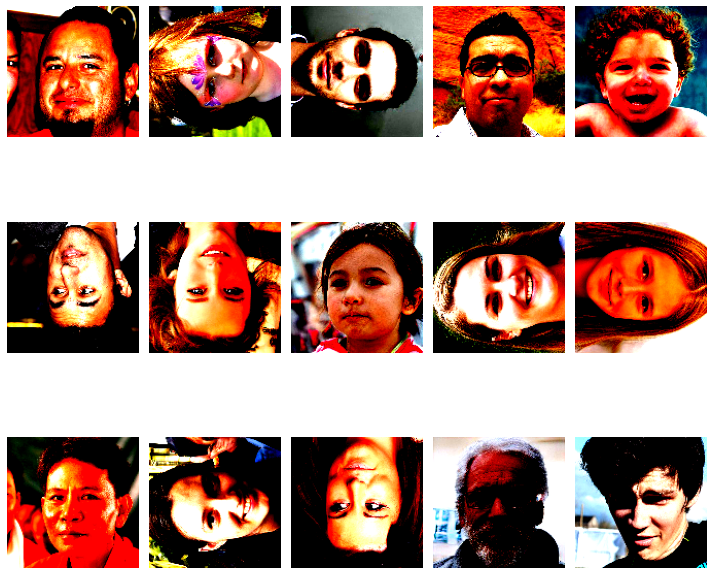

In [12]:
images = [training_set[0][0][i] for i in range(16)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))

axes = axes.flatten()

for img, ax in zip(images, axes):
    ax.imshow(img.reshape(row, col, 3))
    ax.axis('off')

plt.tight_layout()
plt.show()

**Building the Model**

In [13]:
!pip install --quiet vit-keras

from vit_keras import vit

** ViT B32 Model**

In [14]:
vit_model = vit.vit_b32(
        image_size = 128,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 2)

353263616/353253686 [==============================] - 4s 0us/step


In [15]:
vit_model.summary()

Model: "vit-b32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
embedding (Conv2D)           (None, 4, 4, 768)         2360064   
_________________________________________________________________
reshape (Reshape)            (None, 16, 768)           0         
_________________________________________________________________
class_token (ClassToken)     (None, 17, 768)           768       
_________________________________________________________________
Transformer/posembed_input ( (None, 17, 768)           13056     
_________________________________________________________________
Transformer/encoderblock_0 ( ((None, 17, 768), (None,  7087872   
_________________________________________________________________
Transformer/encoderblock_1 ( ((None, 17, 768), (None,  7087

In [16]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(11, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1, 'sigmoid')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vit-b32 (Functional)         (None, 768)               87429888  
_________________________________________________________________
flatten (Flatten)            (None, 768)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 768)               3072      
_________________________________________________________________
dense (Dense)                (None, 11)                8459      
_________________________________________________________________
batch_normalization_1 (Batch (None, 11)                44        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 12        
Total params: 87,441,475
Trainable params: 87,439,917
Non-trainable params: 1,558
________________________________

In [17]:
learning_rate = 1e-4

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.2), 
              metrics = ['accuracy'])

STEP_SIZE_TRAIN = training_set.n // training_set.batch_size
STEP_SIZE_VALID = validation_set.n // validation_set.batch_size

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 2,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'max')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 2,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = './model.hdf5',
                                                  monitor = 'val_accuracy', 
                                                  verbose = 1, 
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

callbacks = [earlystopping, reduce_lr, checkpointer] 

hist = model.fit(x = training_set,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = validation_set,   
          validation_steps = STEP_SIZE_VALID,
          epochs = EPOCHS, 
          callbacks = callbacks) 
  
model.save('model.h5')

Epoch 1/10
1562/1562 [==============================] - 1405s 856ms/step - loss: 0.6135 - accuracy: 0.7270 - val_loss: 0.5390 - val_accuracy: 0.8141

Epoch 00001: val_accuracy improved from -inf to 0.81405, saving model to ./model.hdf5
Epoch 2/10
1562/1562 [==============================] - 1325s 848ms/step - loss: 0.4921 - accuracy: 0.8516 - val_loss: 0.5408 - val_accuracy: 0.8231

Epoch 00002: val_accuracy improved from 0.81405 to 0.82307, saving model to ./model.hdf5
Epoch 3/10
1562/1562 [==============================] - 1338s 856ms/step - loss: 0.4503 - accuracy: 0.8921 - val_loss: 0.5674 - val_accuracy: 0.8042

Epoch 00003: val_accuracy did not improve from 0.82307
Epoch 4/10
1562/1562 [==============================] - 1341s 859ms/step - loss: 0.4289 - accuracy: 0.9125 - val_loss: 0.4876 - val_accuracy: 0.8686

Epoch 00004: val_accuracy improved from 0.82307 to 0.86859, saving model to ./model.hdf5
Epoch 5/10
1562/1562 [==============================] - 1326s 849ms/step - loss: 

**Test Results**

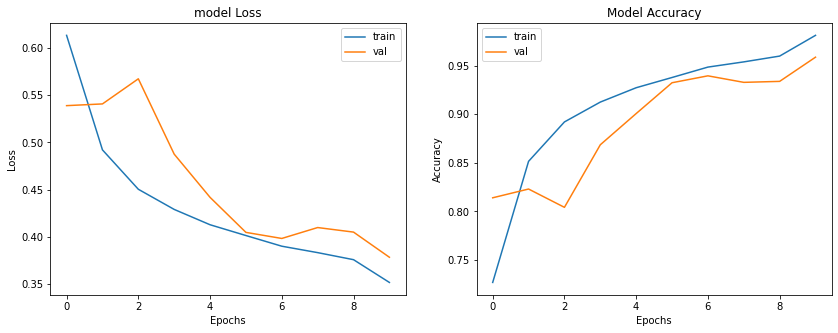

In [18]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.show()

In [19]:
_, accu = model.evaluate(test_set)
print('Final Test Acccuracy = {:.3f}'.format(accu*100))

313/313 [==============================] - 191s 609ms/step - loss: 0.3822 - accuracy: 0.9571
Final Test Acccuracy = 95.710


Confusion Matrix
[[4720 5280]
 [4644 5356]]
Classification Report
              precision    recall  f1-score   support

        fake       0.50      0.47      0.49     10000
        real       0.50      0.54      0.52     10000

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.50      0.50      0.50     20000



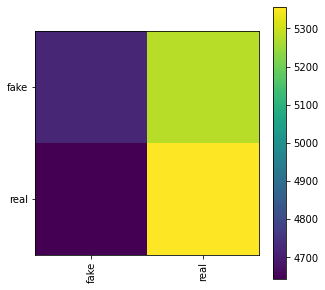

In [20]:
y_pred = model.predict(test_set)
y_pred = (y_pred < 0.5).astype(np.int)

from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm)

names = ['fake', 'real']
print('Classification Report')
print(classification_report(test_set.classes, y_pred, target_names=names))

plt.figure(figsize=(5,5))
plt.imshow(cm)
plt.colorbar()
tick_mark = np.arange(len(names))
_ = plt.xticks(tick_mark, names, rotation=90)
_ = plt.yticks(tick_mark, names)

**Model Architecture**

In [24]:
import os, datetime

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

from PIL import Image
import matplotlib.pyplot as plt

import pydotplus
import pydot

In [25]:
tf.keras.utils.pydot = pydot

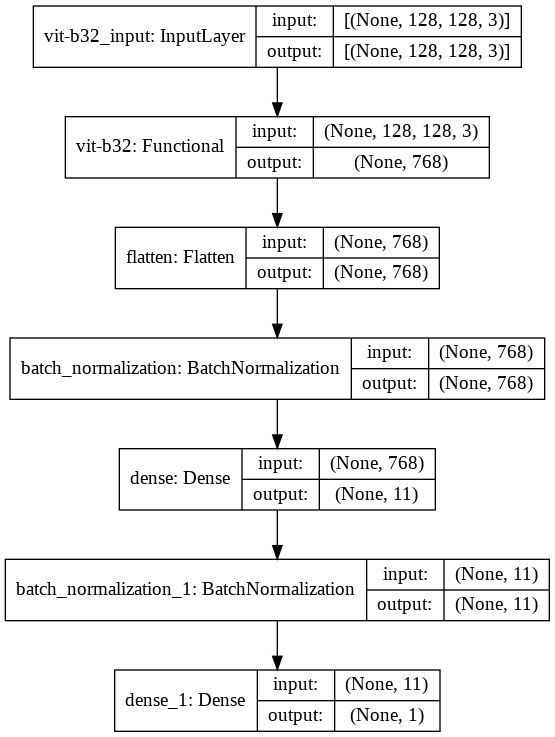

In [26]:
plot_model(model, to_file='model.png', show_shapes=True)